In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Config
input_length = (128, 128, 1)
latent_dim = 128
batch_size = 64
epochs = 15

# Path split
splits_root = r"E:\Skripsi\DEC\dataset\ae-supervised-dataset\split-spectograms"
train_manifest = os.path.join(splits_root, "train.csv")
test_manifest  = os.path.join(splits_root, "test.csv")


In [25]:
def load_spectrogram(path):
    spec = np.load(path).astype(np.float32)  # langsung load numpy array
    return spec

def load_dataset(manifest_csv):
    df = pd.read_csv(manifest_csv)
    X = [load_spectrogram(p) for p in df["path"]]
    X = np.array(X)
    X = np.expand_dims(X, -1)   # (N, H, W, 1)   # shape (N, 3001, 1)
    return X, df["label"].values


In [12]:
X_train, y_train = load_dataset(train_manifest)
X_test, y_test   = load_dataset(test_manifest)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (3861, 128, 128, 1)
Test shape : (966, 128, 128, 1)


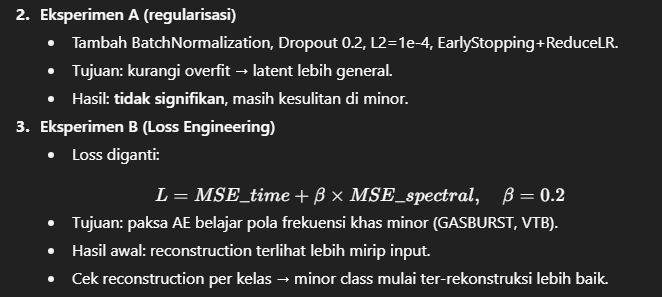

In [42]:
def build_autoencoder(input_length, latent_dim):
    inp = keras.Input(shape=(input_length))

    # === Encoder ===
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)   # (60,60,32)

    x = layers.Conv2D(64, (3,3), padding="same", activation="relu",
                      kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)   # (30,30,64)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)   # (15,15,128)

    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name="latent")(x)

    # === Decoder ===
    x = layers.Dense(16*16*128)(latent)
    x = layers.Reshape((16,16,128))(x)

    x = layers.Conv2DTranspose(64, (3,3), strides=2, padding="same", activation="relu")(x)  # (30,30,64)
    x = layers.Conv2DTranspose(32, (3,3), strides=2, padding="same", activation="relu")(x)  # (60,60,32)
    x = layers.Conv2DTranspose(1, (3,3), strides=2, padding="same")(x)                      # (120,120,1)

    model = keras.Model(inp, x, name="CAE_2D")
    encoder = keras.Model(inp, latent, name="Encoder_2D")
    return model, encoder


In [43]:
model, encoder = build_autoencoder(input_length, latent_dim)
print(input_length)
latent_dim = encoder.output_shape[1]
print(f"Encoder loaded. Latent dim = {latent_dim}")


(128, 128, 1)
Encoder loaded. Latent dim = 128


In [44]:
model.summary()

encoder.summary()

Model: "CAE_2D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32768)          │     4,227,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 1)    │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,607,617 (32.84 MB)

 Trainable params: 8,607,169 (32.83 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "Encoder_2D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 128)            │     4,194,432 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,000 (16.36 MB)

 Trainable params: 4,287,552 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [45]:

def spectral_mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


In [46]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=spectral_mse_loss, metrics=["mse"])

callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
  tf.keras.callbacks.ModelCheckpoint("best_ae.h5", monitor="val_loss", save_best_only=True),
  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
]

history = model.fit(
    X_train, X_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1
)


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.0374 - mse: 0.0339 - val_loss: 0.2036 - val_mse: 0.2007
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 0.0117 - mse: 0.0092 - val_loss: 0.1986 - val_mse: 0.1966
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 76s 961ms/step - loss: 0.0100 - mse: 0.0083 - val_loss: 0.1755 - val_mse: 0.1740
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 53s 959ms/step - loss: 0.0089 - mse: 0.0077 - val_loss: 0.1504 - val_mse: 0.1494
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 52s 951ms/step - loss: 0.0083 - mse: 0.0074 - val_loss: 0.1277 - val_mse: 0.1269
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 53s 956ms/step - loss: 0.0079 - mse: 0.0072 - val_loss: 0.1074 - val_mse: 0.1068
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - loss: 0.0077 - mse: 0.0072 - val_loss: 0.0806 - val_mse: 0.0801
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - loss: 0.0075 - mse: 0.0071 - val_loss: 0.0461 - val_mse: 0.0458
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 53s 960ms/step -

In [47]:
# Simpan hanya encoder
encoder = keras.Model(model.input, model.get_layer("latent").output)
encoder.save("encoder.h5")

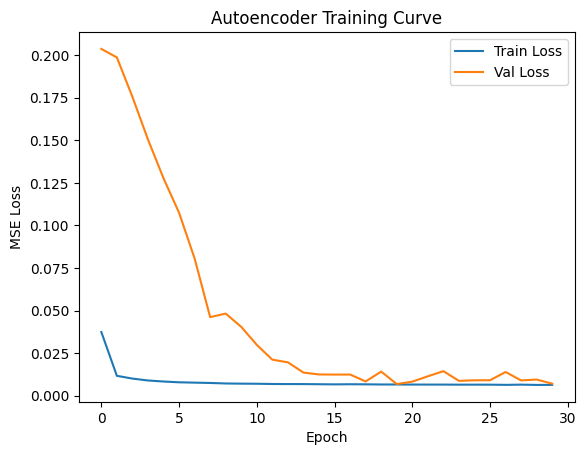

In [48]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Autoencoder Training Curve")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


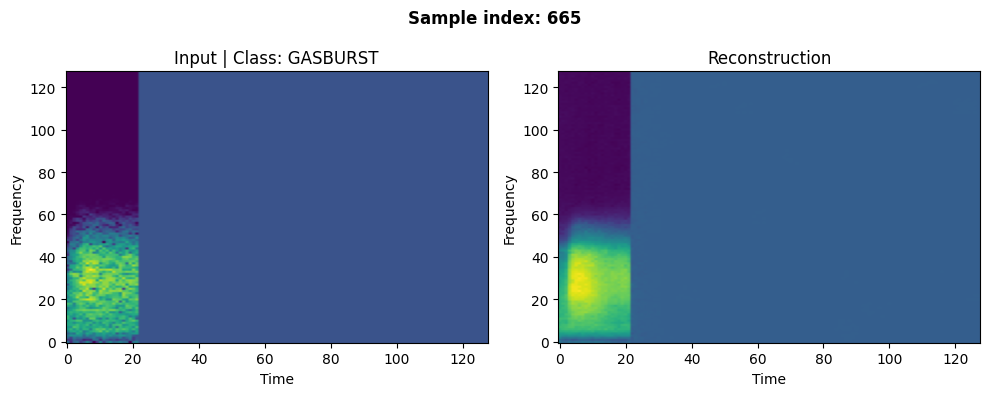

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


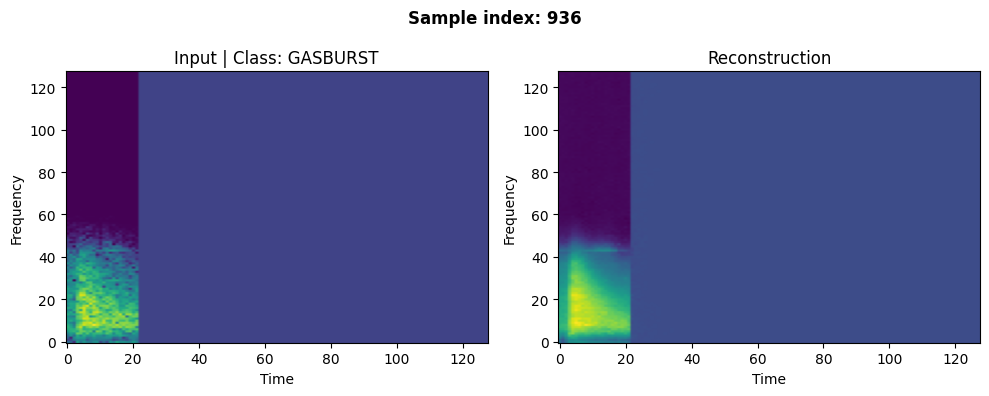

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


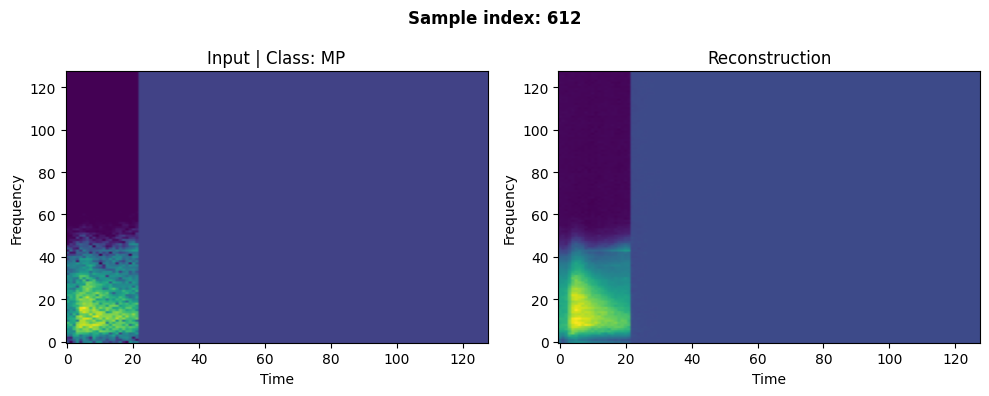

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


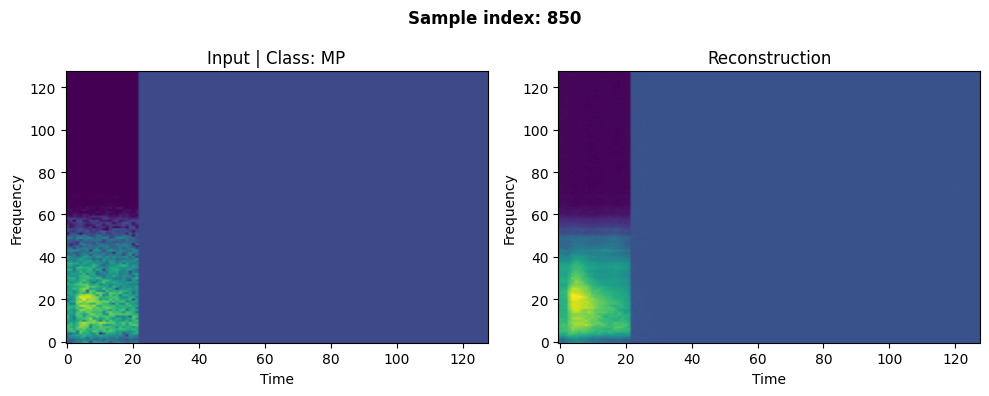

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


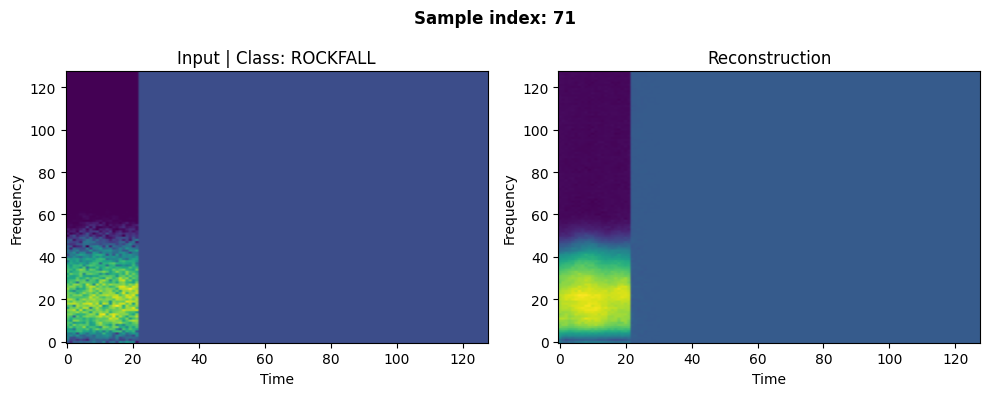

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


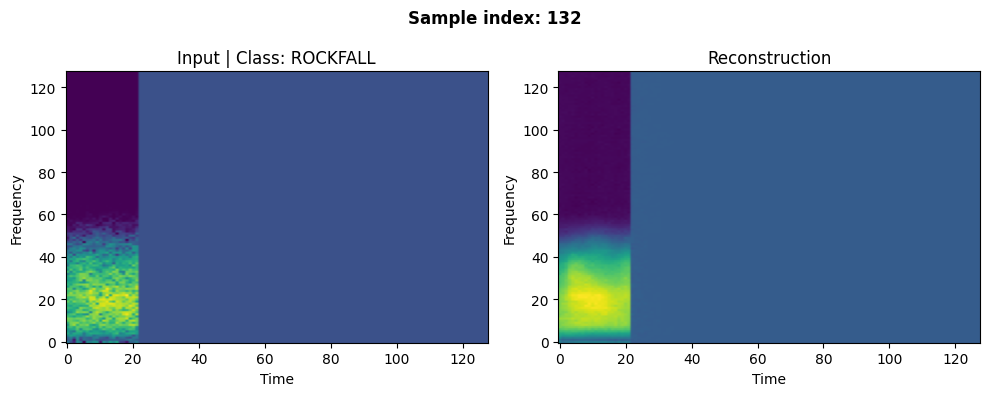

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


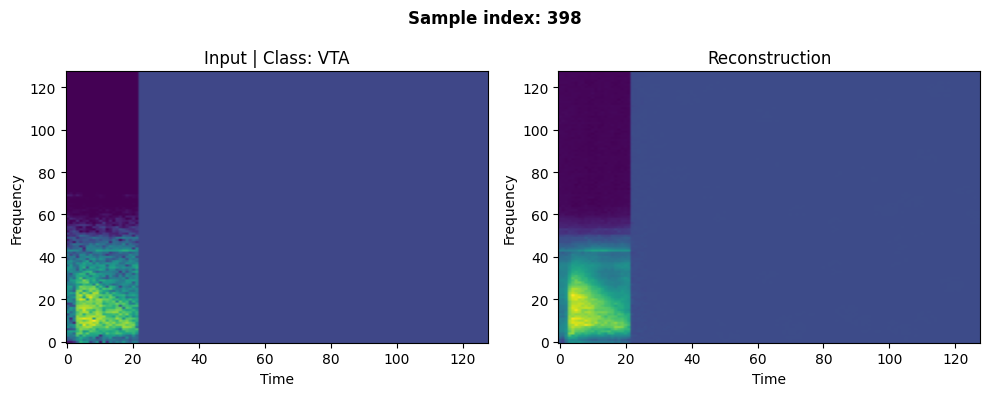

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


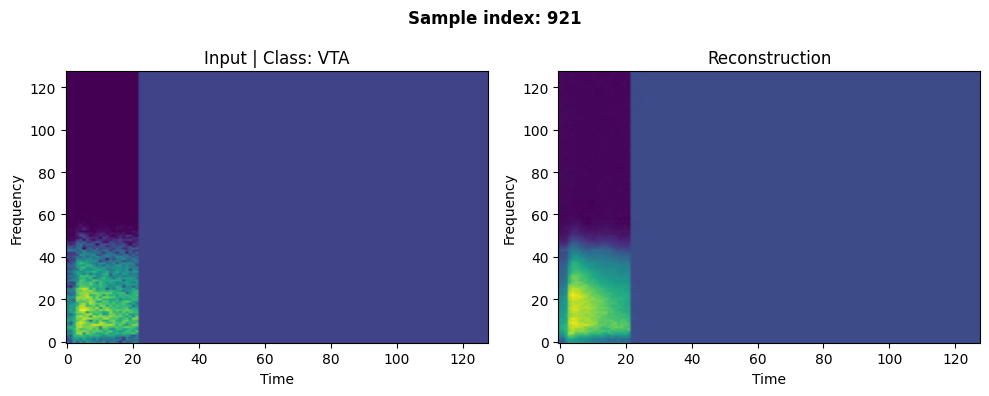

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


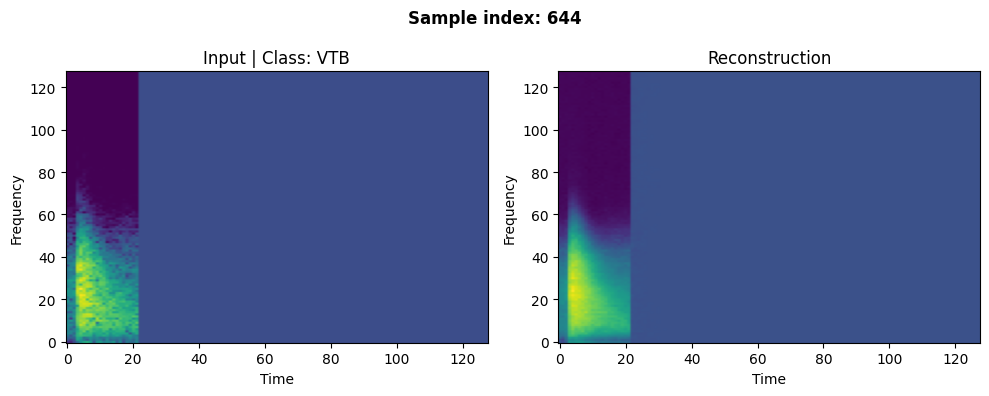

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


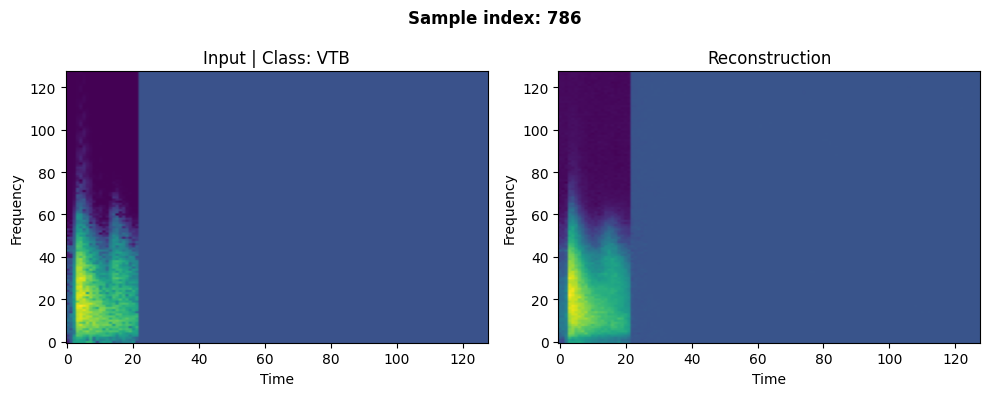

In [54]:
import random

def plot_reconstruction_examples_2d(model, X, y, n_classes=5, n_samples=1):
    labels = np.unique(y)
    for label in labels[:n_classes]:
        idxs = np.where(y == label)[0]
        for _ in range(n_samples):
            sample_idx = random.choice(idxs)
            x_in = X[sample_idx:sample_idx+1]   # shape (1,128,128,1)
            x_out = model.predict(x_in)

            fig, axes = plt.subplots(1, 2, figsize=(10,4))
            
            # Input
            axes[0].imshow(x_in[0,:,:,0], aspect='auto', origin='lower', cmap='viridis')
            axes[0].set_title(f"Input | Class: {label}")
            axes[0].set_xlabel("Time")
            axes[0].set_ylabel("Frequency")
            
            # Reconstruction
            axes[1].imshow(x_out[0,:,:,0], aspect='auto', origin='lower', cmap='viridis')
            axes[1].set_title("Reconstruction")
            axes[1].set_xlabel("Time")
            axes[1].set_ylabel("Frequency")

            plt.suptitle(f"Sample index: {sample_idx}", fontsize=12, weight="bold")
            plt.tight_layout()
            plt.show()

plot_reconstruction_examples_2d(model, X_test, y_test, n_classes=5, n_samples=2)
